# Gaussian HMM

<br>

### Reading in Data & Basic Checks

In [1]:
import pandas as pd
import numpy as np

import scipy

from datetime import datetime, time, date

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from hmmlearn.hmm import GaussianHMM

import random

In [2]:
df_hierro = pd.read_csv('data/df_hierro_clean.csv', parse_dates=['datetime'])
df_hierro.head()

,datetime,demand,diesel,wind,pump_hydro,dsch_hydro
0,2016-01-01 00:00:00,5.1,5.2,0.0,0.0,0.0
1,2016-01-01 00:10:00,5.1,5.2,0.0,0.0,0.0
2,2016-01-01 00:20:00,5.3,5.4,0.0,0.0,0.0
3,2016-01-01 00:30:00,5.3,5.4,0.0,0.0,0.0
4,2016-01-01 00:40:00,5.3,5.4,0.0,0.0,0.0


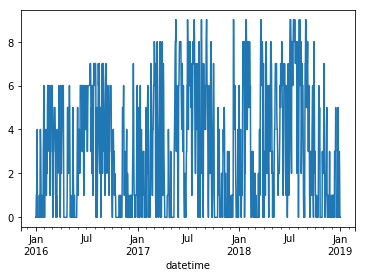

In [3]:
s_wind_days = df_hierro.set_index('datetime').resample('D').mean().wind
s_wind_days_class = s_wind_days.apply(lambda x: int(x))

s_wind_days_class.plot()

In [4]:
s_wind = df_hierro.set_index('datetime').wind
training_data = np.column_stack([s_wind])#, s_wind_days_1, s_wind_days_2, s_wind_days_3])

In [5]:
hmm = GaussianHMM(n_components = 10, covariance_type = 'diag', n_iter = 1000)
hmm.fit(training_data)

num_samples = 52560
samples, _ = hmm.sample(num_samples)

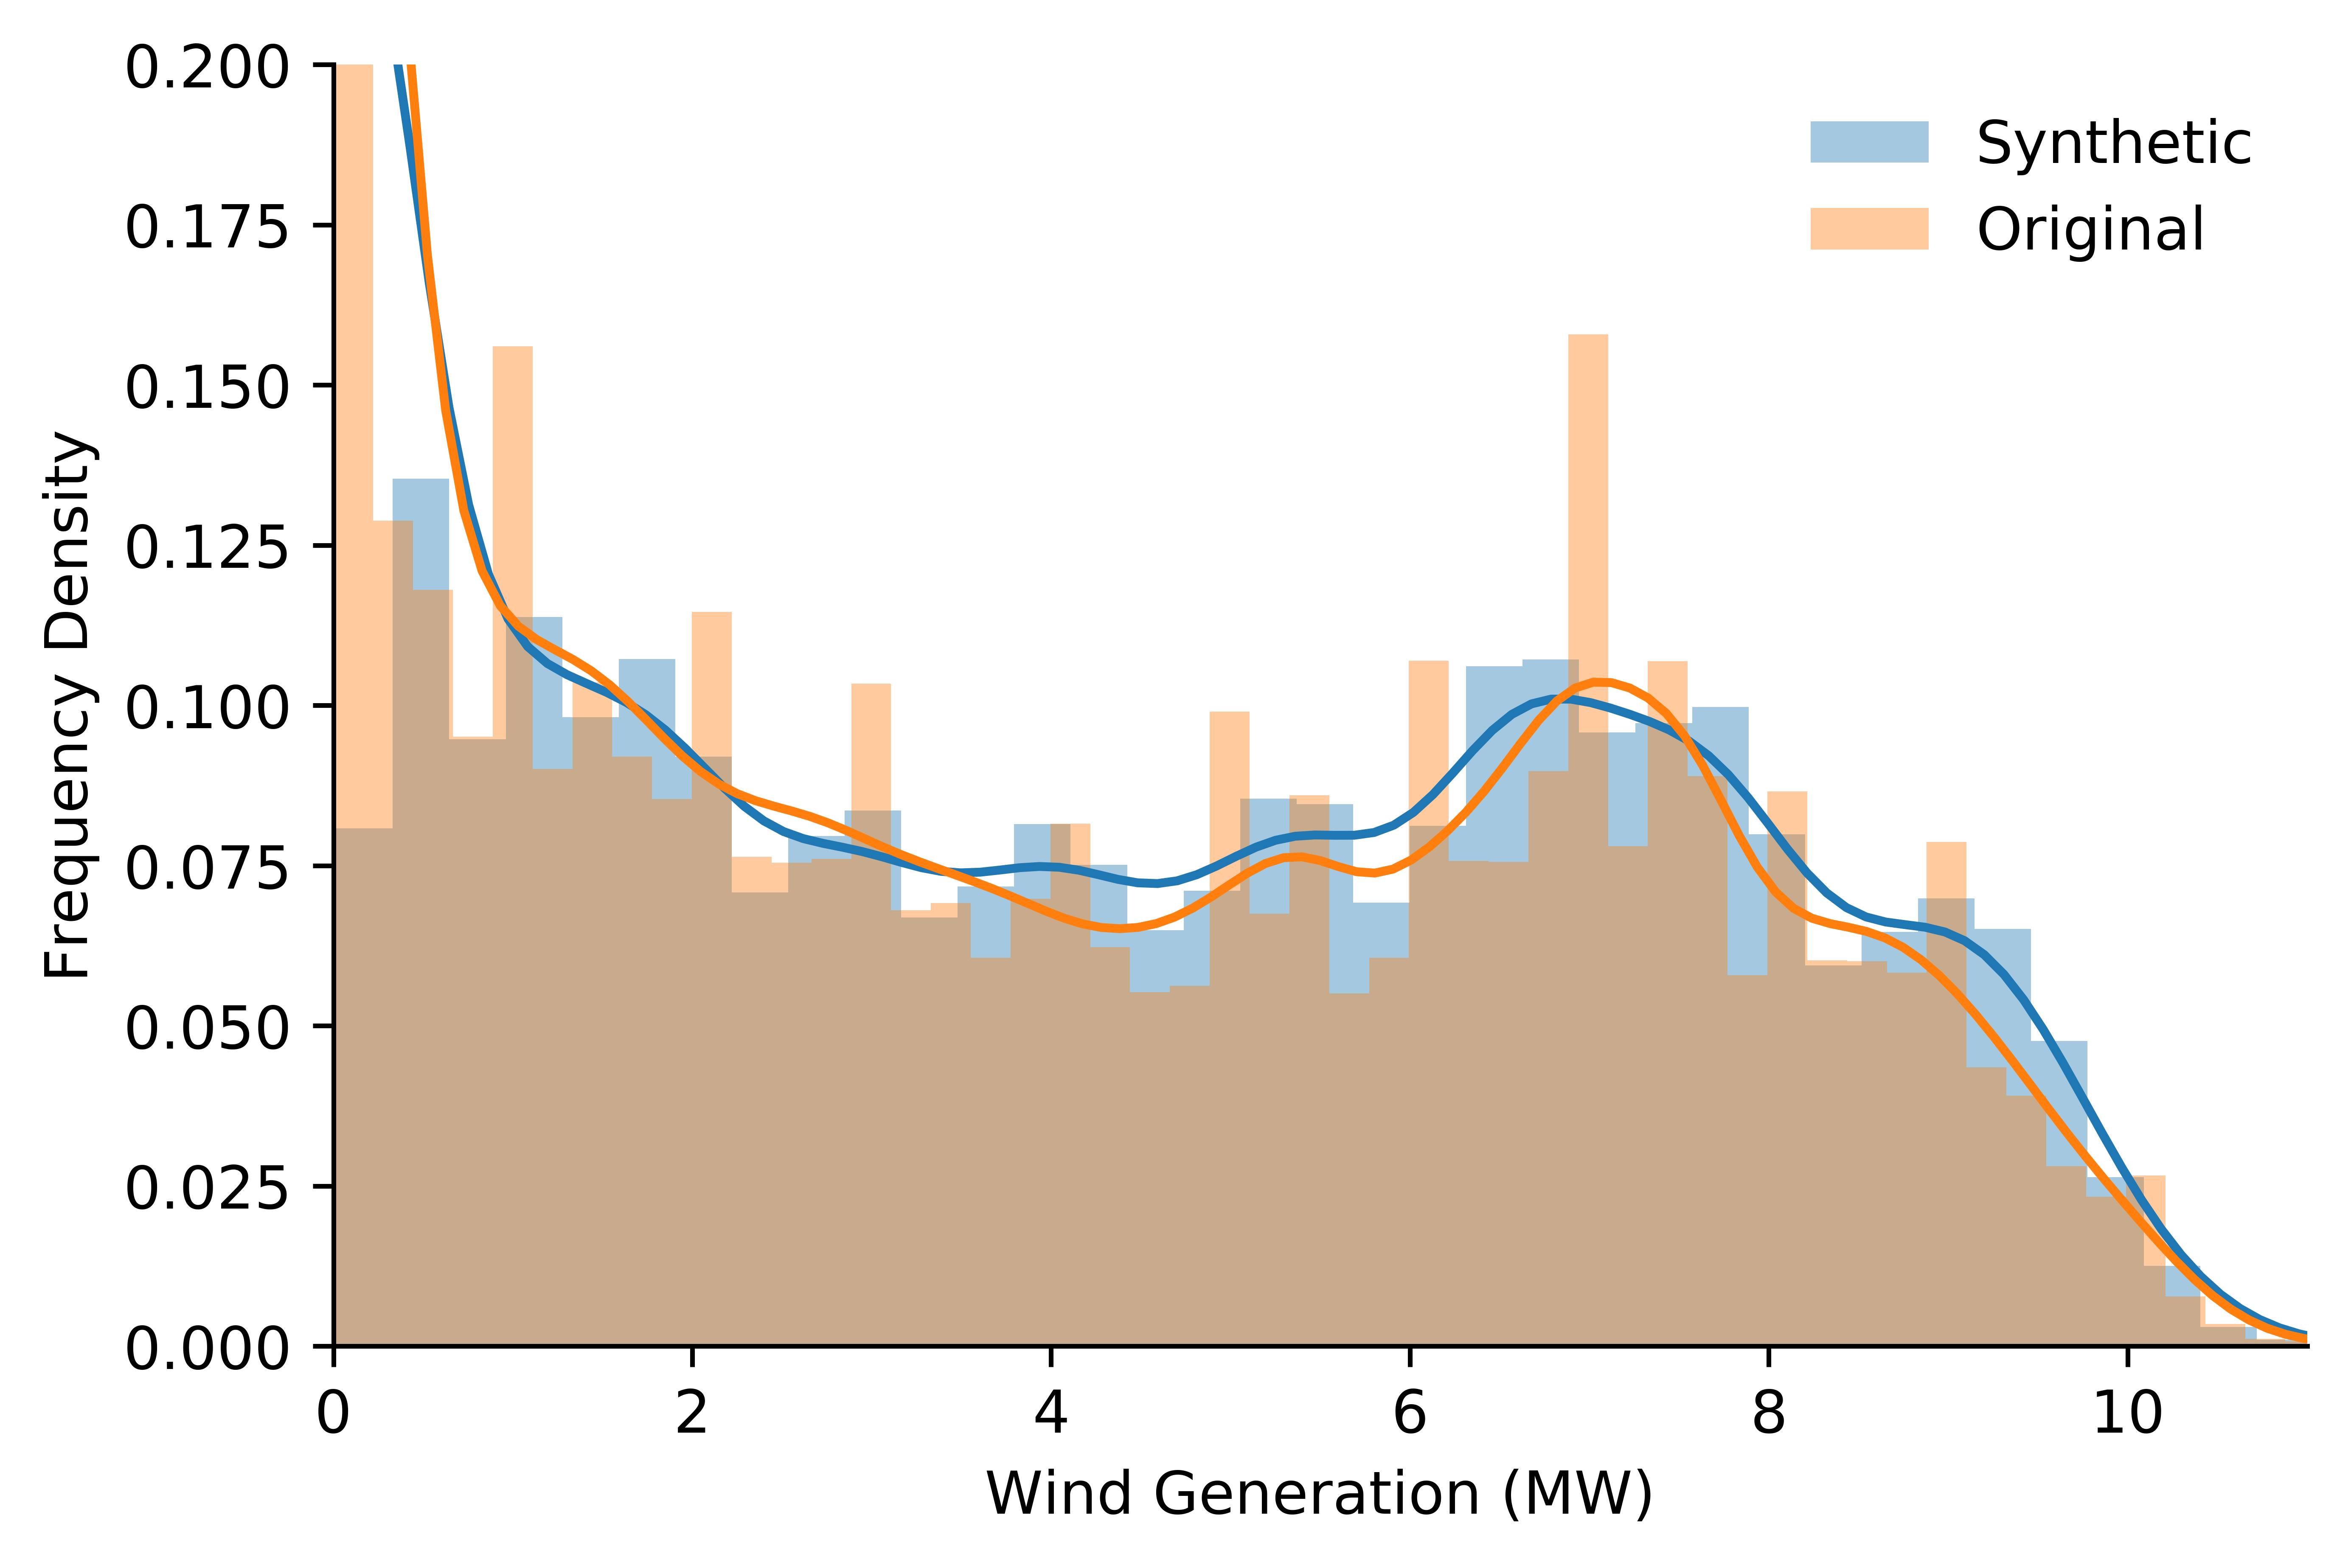

In [35]:
s_samples = pd.Series([x[0] for x in list(samples)])
s_training = pd.Series([x[0] for x in list(training_data)])

## Plotting
fig = plt.figure(dpi=150)
ax = plt.subplot()

sns.distplot(s_samples, label='Synthetic', ax=ax)
sns.distplot(s_training,label='Original', ax=ax)

plt.xlim(0, 11)
plt.ylim(0, 0.2)

plt.legend(frameon=False)
plt.ylabel('Frequency Density')
plt.xlabel('Wind Generation (MW)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('img/HMM_distribution_comparison.png')

In [18]:
scipy.stats.ks_2samp(s_samples, s_training)

Ks_2sampResult(statistic=0.1, pvalue=0.0)

In [19]:
s_training.shape

(170694,)

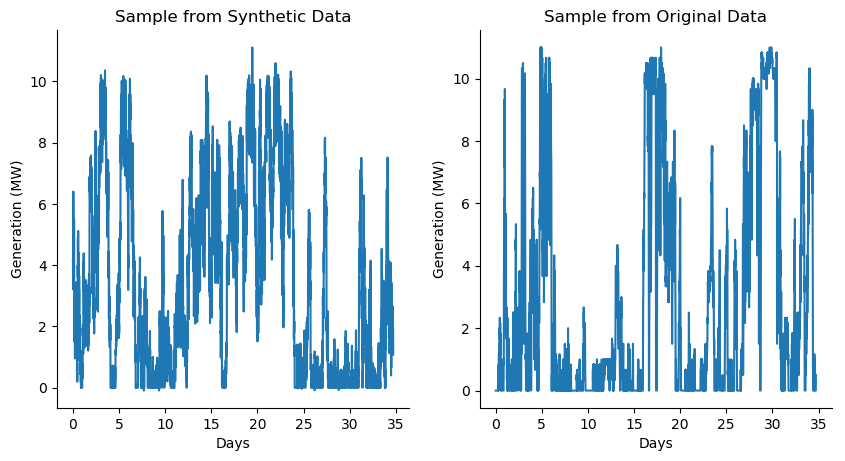

In [24]:
samples, _ = hmm.sample(num_samples, random_state=2)
start = 5*5000

## Plotting
fig = plt.figure(figsize=(10, 5), dpi=100)
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

s_synth = s_samples[start:5000+start].reset_index(drop=True)
s_synth.index = s_synth.index/(6*24)
s_synth.plot(ax=ax1)
ax1.set_title('Sample from Synthetic Data')
ax1.set_xlabel('Days')
ax1.set_ylabel('Generation (MW)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

x = 0
s_orig = s_training[x:x+5000]*10/6
s_orig.index = s_orig.index/(6*24)
s_orig.plot(ax=ax2)
ax2.set_title('Sample from Original Data')
ax2.set_xlabel('Days')
ax2.set_ylabel('Generation (MW)')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.savefig('img/HMM_comparison.png')

In [28]:
s_training = pd.Series([x[0] for x in list(training_data)])
s_predicted_state = pd.Series(hmm.predict(training_data))

1008

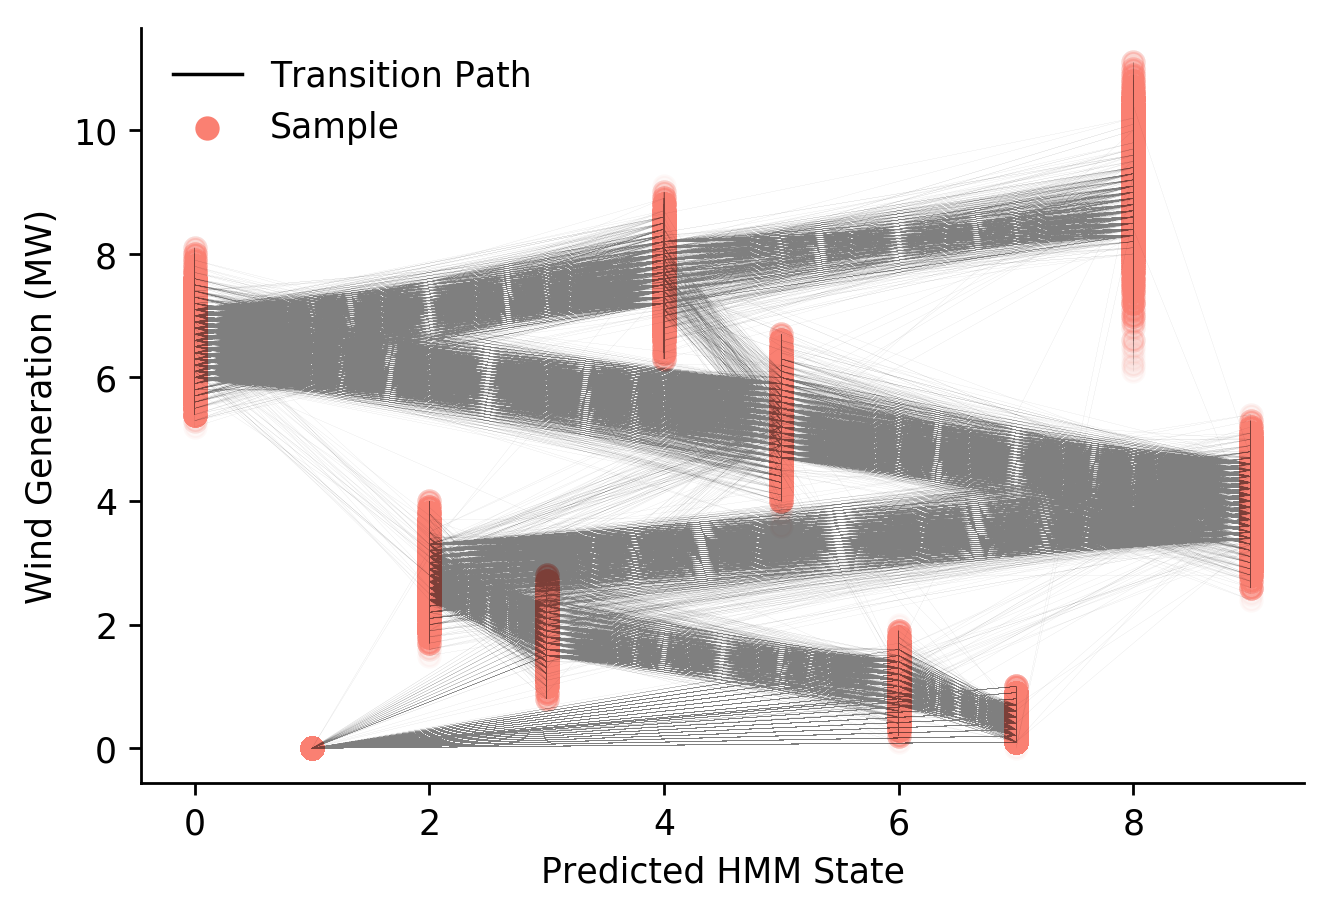

In [33]:
fig = plt.figure(dpi=250)
ax = plt.subplot()

ax.scatter(s_predicted_state, s_training, color='salmon', alpha=0.05, label='Sample')
ax.plot(s_predicted_state, s_training, color='k', alpha=0.5, label='Transition Path', linewidth=0.01) #mediumturquoise

plt.xlabel('Predicted HMM State')
plt.ylabel('Wind Generation (MW)')

leg = plt.legend(frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_linewidth(1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('img/HMM_transition_states.png')

In [30]:
dt_rng.shape

(52560,)

In [31]:
len(samples)

52560

In [32]:
min_date = pd.datetime(2021, 1, 1, 0, 0)
max_date = pd.datetime(2021, 12, 31, 23, 50)

dt_rng = pd.date_range(min_date, max_date, freq='10T')

In [33]:
df_wind_hmm = pd.DataFrame({'datetime':dt_rng, 'wind_hmm':[x[0] for x in list(samples)]})
df_wind_hmm.at[df_wind_hmm['wind_hmm']<0, 'wind_hmm'] = 0
df_wind_hmm.head()

,datetime,wind_hmm
0,2021-01-01 00:00:00,0.000025
1,2021-01-01 00:10:00,0.000000
2,2021-01-01 00:20:00,0.000000
3,2021-01-01 00:30:00,0.000000
4,2021-01-01 00:40:00,0.000410


In [34]:
df_wind_hmm.to_csv('data/synth_wind_hmm.csv', index=False)